### ⚠️ Roteiro para executar códigos do notebook no Google Colab(oratory) com GPU_


**PASSO 1:** Acessar https://colab.research.google.com/ $\to$ `Upload` $\to$ `escolher arquivo .ipynb`

**PASSO 2:** Acessar MENU `Ambiente de execução` $\to$ `Alterar tipo do ambiente` $\to$ `GPU` $\to$ `Salvar`

**PASSO 3:** `Barra lateral esquerda` $\to$ `Icone de arquivo` $\to$ `Icone de upload` $\to$ `escolher arquivo auxiliar` (ex. `aux.py`)

**PASSOS 4, 5, 6 e 7:** ver células a seguir...

In [ ]:
#### PASSO 4: VER DETALHES DA GPU
#### Descomente a linha abaixo e execute

#!nvidia-smi

In [ ]:
#### PASSO 5: VER VERSÃO CUDA INSTALADA
#### Descomente a linha abaixo e execute

#!nvcc --version 

In [ ]:
#### PASSO 6: INSTALAR versão MXNET com versão CUDA correspondente
#### Descomente uma das linhas abaixo e execute

#!pip install -U mxnet-cu110==1.8.0 
#!pip install -U mxnet-cu101==1.7.0

In [ ]:
#### PASSO 7: VERIFICAR se MXNET "enxerga" a GPU
#### Se estiver enxergando, será impresso algo como gpu(0),
#### caso contrário, será impresso algo como cpu(0)
#### Descomente o código abaixo e execute

#from mxnet import npx
#def try_all_gpus():
#    devices = [npx.gpu(i) for i in range(npx.num_gpus())]
#    return devices if devices else [npx.cpu()]
#try_all_gpus()

## Até agora assumimos que:

1. Dados são extraídos de alguma distribuição: $(\mathbf{x},y) \sim P(\mathbf{x},y)$; e
2. Exemplos são distribuídos de forma independente e idêntica;

$\to$ A **ordem** dos dados tabulados ou imagens para tarefas de classificação ou regressão **não importa muito**. 

## Já para...

1. Vídeo: (seq de quadros)
2. Áudio: seq de fonemas
3. Texto: seq de palavras (ou caracteres)
4. Navegação em um site: seq de comportamentos
5. Previsão de valores: seq temporal

O que possuem em comum? A **SEQUÊNCIA** é **importante para a compreensão do significado**!


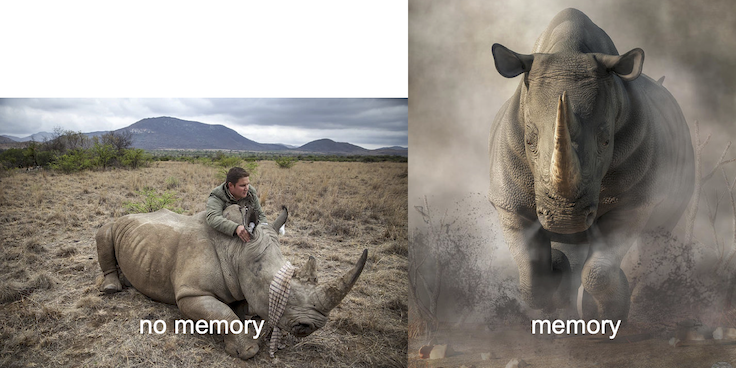

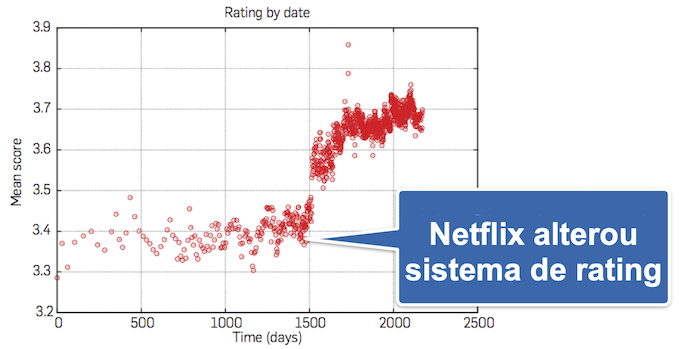

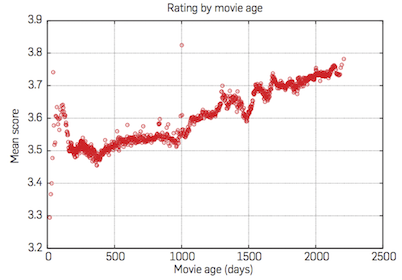

## Modelos autoregressivos

Uma tentativa de reaproveitar um modelo de regressão, por exemplo, para prever a nota a ser dada a um filme em um determinado dia $t$ poderia usar as notas anteriores ao longo do tempo: $x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$. 

PROBLEMA: número de entradas da rede varia com o tempo.

Uma abordagem: 
$$P(x_t \mid x_{t-1}, \ldots, x_1) \to P(x_t \mid x_{t-1}, \ldots, x_{t-\tau})$$
$$\to \hat{x}_t = f(x_{t-1},...,x_{t-\tau})$$ 

Apenas uma fração do tempo passado importa: **SUPOSIÇÃO DE MARKOV**.

Ex. $\tau = 2 \to$ **MODELO DE MARKOV de 2a ordem**

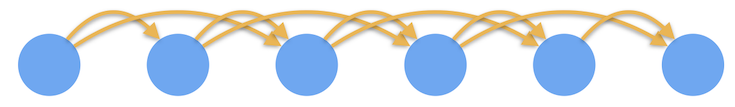

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1},x_{t-2})$$

## _Warmup_: criação artificial de dados temporais

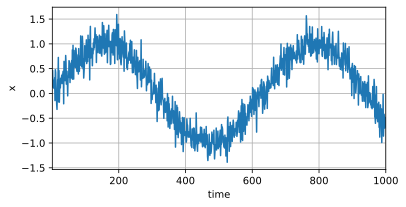

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
import aux

npx.set_np()

T = 1000  # Gerar 1000 pontos artificialmente (t0 --> t1000)
time = np.arange(1, T + 1, dtype=np.float32)
x = np.sin(0.01 * time) + np.random.normal(0, 0.2, (T,)) #Função seno com ruído aditivo
aux.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

### Geração de um _dataset_ para Regressão

Transformar os dados de sequência em rótulos e características:    
$y_t = x_t$  
$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$

Com $\tau = 4$ temos:
- 4 colunas (características)
- 996 linhas (exemplos)

$\hat{x}_{1000} = f(x_{999},...,x_{996})$,   
$\hat{x}_{999} = f(x_{998},...,x_{995})$,   
...,     
$\hat{x}_{5} = f(x_{4},...,x_{1})$   

Vamos considerar apenas os **600 primeiros exemplos** gerados como nosso **dataset de treinamento**.

In [2]:
tau = 4
features = np.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Apenas os primeiros `n_train` exemplos são usados para treinamento
train_iter = aux.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

### Arquitetura da rede neuronal

MLP de 2 camadas:   
- Camada escondida: 10 neurônios
- Camada de saída: 1 neurônio (valor a ser previsto)
- função de ativação ReLU
- função de erro quadrática

In [3]:
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(10, activation='relu'), nn.Dense(1))
    net.initialize(init.Xavier())
    return net

loss = gluon.loss.L2Loss()

In [4]:
def train(net, train_iter, loss, epochs, lr):
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    for epoch in range(epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        print(f'epoch {epoch + 1}, '
              f'loss: {aux.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.041775
epoch 2, loss: 0.030933
epoch 3, loss: 0.029241
epoch 4, loss: 0.027870
epoch 5, loss: 0.027480


### Previsão para $t+1$

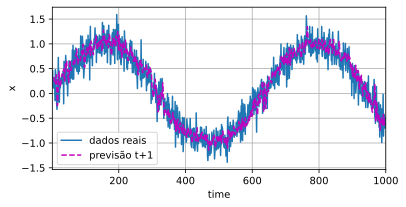

In [5]:
onestep_preds = net(features)
aux.plot([time, time[tau:]],
         [x.asnumpy(), onestep_preds.asnumpy()], 'time', 'x',
         legend=['dados reais', 'previsão t+1'], xlim=[1, 1000], figsize=(6, 3))

⚠️ Mesmo considerando apenas os 600 primeiros exemplos para treinamento, observe que o modelo aparenta funcionar muito bem para instantes $t > 601$:    
$\hat{x}_{602} = f(x_{601}, x_{600}, x_{599}, x_{598})$,    
...,    
$\hat{x}_{911} = f(x_{910}, x_{909}, x_{908}, x_{907})$,   
....

### Previsão para $t+k$

Mas caso queiramos realizar uma previsão para um instante futuro mais distante, a coisa complica. Precisamos usar as próprias previsões obtidas como características para prever o instante futuro: **bola de neve de erros acumulados**.

Ex: previsões (em toda a sequência) para 1 dia, 1 semana, 1 mês, 2 meses:    
$𝑘=1,7,30,60$

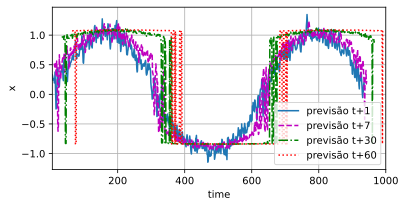

In [6]:
max_steps = 64

features = np.zeros((T - tau - max_steps + 1, tau + max_steps))

for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 7, 30, 60)
aux.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].asnumpy() for i in steps], 'time', 'x',
         legend=[f'previsão t+{i}'
                 for i in steps], xlim=[5, 1000], figsize=(6, 3))

## Tarefa: Processamento de Texto

Sem dúvidas, a tarefa de previsão de sequências mais popular!

### Etapa de _Preprocessamento_

Etapa necessária para representar adequadamente o texto na forma de características apropriadas para modelos de aprendizado:
1. Representar o texto como strings na memória (LEITURA)
2. Dividir as strings (ex. em palavras e/ou caracteres) (TOKENIZAÇÃO)
3. Construir tabela de vocabulário para mapear os tokens em índices numéricos (VOCABULÁRIO)
4. Converter texto em seqüências de índices numéricos.

In [7]:
import collections
import re
import aux
import os
import requests

#### LEITURA

In [8]:
def download(url, cache_dir=os.path.join('.', 'data')):
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    print(f'Fazendo download do arquivo {fname} de {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [9]:
# Livro Frankenstein, de Mary Shelley
url = "https://www.gutenberg.org/files/84/84-0.txt"

# Carrega o livro como uma lista de linhas de texto.
def read_url(): 
    with open(download(url), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_url()
print(f'# linhas de texto: {len(lines)}')
print(lines[0])
print(lines[10])

Fazendo download do arquivo ./data/84-0.txt de https://www.gutenberg.org/files/84/84-0.txt...
# linhas de texto: 7743
the project gutenberg ebook of frankenstein by mary wollstonecraft godwin shelley
title frankenstein


#### TOKENIZAÇÃO

In [10]:
def tokenize(lines, token='word'): 
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERRO: tipo de token desconhecido: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'project', 'gutenberg', 'ebook', 'of', 'frankenstein', 'by', 'mary', 'wollstonecraft', 'godwin', 'shelley']
[]
['this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'in', 'the', 'united', 'states', 'and']
['most', 'other', 'parts', 'of', 'the', 'world', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions']
['whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms']
['of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook', 'or', 'online', 'at']
['www', 'gutenberg', 'org', 'if', 'you', 'are', 'not', 'located', 'in', 'the', 'united', 'states', 'you']
['will', 'have', 'to', 'check', 'the', 'laws', 'of', 'the', 'country', 'where', 'you', 'are', 'located', 'before']
['using', 'this', 'ebook']
[]
['title', 'frankenstein']


#### VOCABULÁRIO

É construído a partir do livro/texto lido.

1. Contagem de tokens únicos em todos os documentos do conjunto de treinamento (**_Corpus_**);
2. Atribui-se um índice numérico a cada token único de acordo com sua freqüência;
3. Tokens raros são removidos para reduzir a complexidade (dimensão);
4. Tokens especiais podem ser utilizados: "\<unk>", "\<pad>", "\<bos>", "\<eos>".

In [11]:
class Vocab:  #@save
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Ordena segundo frequências de aparição
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # O índice do token <unk> é 0 (zero)
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):  
    # tokens` é uma lista 1D ou 2D
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Transforma uma lista de listas de token em uma lista de tokens.
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [12]:
# Construção do vocabulário
vocab = Vocab(tokens)
# Impressão dos tokens mais frequentes e seus respectivos índices
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('and', 2), ('i', 3), ('of', 4), ('to', 5), ('my', 6), ('a', 7), ('in', 8), ('that', 9)]


In [13]:
# Cada linha de texto é transformada em uma lista de índices
for i in [0, 10]:
    print('palavras:', tokens[i])
    print('índices:', vocab[tokens[i]])

palavras: ['the', 'project', 'gutenberg', 'ebook', 'of', 'frankenstein', 'by', 'mary', 'wollstonecraft', 'godwin', 'shelley']
índices: [1, 101, 87, 684, 4, 275, 23, 2349, 2350, 2351, 2352]
palavras: ['title', 'frankenstein']
índices: [3028, 275]


#### Juntando tudo!

Função que retorna lista de índices dos tokens (_corpus_) e seu vocabulário.   

In [14]:
def load_corpus(max_tokens=-1): 
    lines = read_url()
    tokens = tokenize(lines, 'word')
    vocab = Vocab(tokens)
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus()
# Impressão do tamanho do corpus e do vocabulário
len(corpus), len(vocab)

Fazendo download do arquivo ./data/84-0.txt de https://www.gutenberg.org/files/84/84-0.txt...


(78471, 7262)

## Modelos de Linguagem

Objetivo de estimar a probabilidade conjunta de uma sequência de palavras (por exemplo): $P(w_1, w_2, \ldots, w_T)$

Exemplo: geração de texto    
- $w_t \sim P(w_t \mid w_{t-1}, \ldots, w_1)$  (uma palavra por vez)    

Exemplo: probabilidade de uma dada sequencia de texto    
- $P(\text{aprendizado}, \text{profundo}, \text{é}, \text{fácil}) =  P(\text{aprendizado}) P(\text{profundo}  \mid  \text{aprendizado}) P(\text{é}  \mid  \text{aprendizado}, \text{profundo}) P(\text{fácil}  \mid  \text{aprendizado}, \text{profundo}, \text{é})$

**Como estimar?**

$$\hat{P}(\text{profundo} \mid \text{aprendizado}) = \frac{n(\text{aprendizado, profundo})}{n(\text{aprendizado})}$$,    
onde $n$ representa o número de aparições da palavra ou pares de palavras no texto ou triplas ou ...

**_Laplace Smoothing_** para resolver o problema do caso $n(x) = 0$ ou $n(x, x') = 0$ ou $n(x, x'', x''') = 0$, etc...

$$\begin{split}\begin{aligned}
    \hat{P}(x) & = \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
    \hat{P}(x' \mid x) & = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
    \hat{P}(x'' \mid x,x') & = \frac{n(x, x',x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}
\end{aligned}\end{split}$$,
onde $m$ é o número de palavras únicas e $\epsilon$ é um hiperparâmetro de controle da intensidade do _smoothing_.

**Enxergando os Modelos de Markov nos modelos de linguagem...**

$$\begin{split}\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3),\\
etc.
\end{aligned}\end{split}$$

Respectivamente, _unigram_, _bigram_, _trigram_, ...
 **_n-gram_**.

### Sugestão: acompanhar codificação da seção 8.3 de [Dive into Deep Learning](https://d2l.ai/index.html)

### Problema: muitos _n-grams_ ocorrem muito raramente

$\to$ _Laplace smoothing_ se torna então bem inadequado para a modelagem de linguagem.

### Problema: considerar histórico maior de dependência custa caro (_n_ grande)

### Alternativa: ...

# ...Redes Neurais Recorrentes!

$P(x_t \mid x_{t-1}, \ldots, x_1) \approx P(x_t \mid h_{t-1})$,

onde $h_{t-1}$ é um **estado (ou variável) oculto** que armazena a sequência de informação até instante $t-1$.

Usualmente, o estado oculto num instante $t$ é computado a partir da observação corrente, $x_t$ e estado oculto anterior, $h_{t-1}$.

$h_t = f(x_{t}, h_{t-1})$

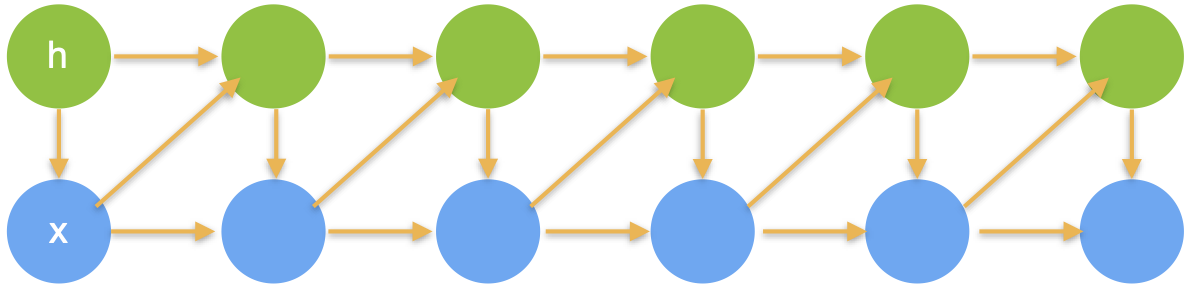

### $\to$ Redes Neurais Recorrentes $=$ Redes Neurais com estados ocultos

## Formalização

Considere um minibatch de $n$ exemplos de sequências:

$\mathbf{X}_t \in \mathbb{R}^{n \times d}$, onde cada linha de $\mathbf{X}_t$ é um exemplo no instante $t$ da sequência.

Considere também $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ como a variavel escondida no instante $t$.

Novo parâmetro de peso para descrever como usar a variável oculta do instante anterior no instante atual: $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$

Assim...
$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$

[_obs:_ $\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}$ $\equiv$ $concat(\mathbf{X}_t \mathbf{H}_{t-1}) concat(\mathbf{W}_{xh} \mathbf{W}_{hh})$ ]

Essas variáveis $\mathbf{H}$ guardam as informações históricas da seqüência até o instante atual. Como o estado oculto usa a mesma definição do instante $t$ anterior, esse **cálculo é recorrente**.

Para um instante $t$, a saída da camada de saída da rede é semelhante ao que é feito na MLP:

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

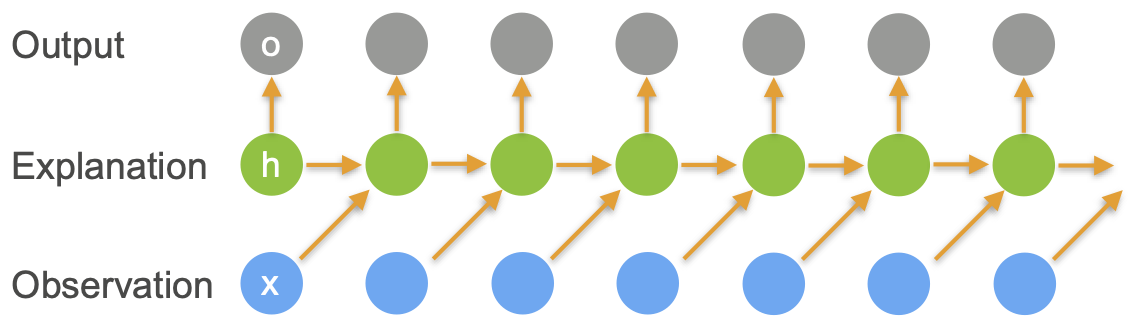

## Arquitetura

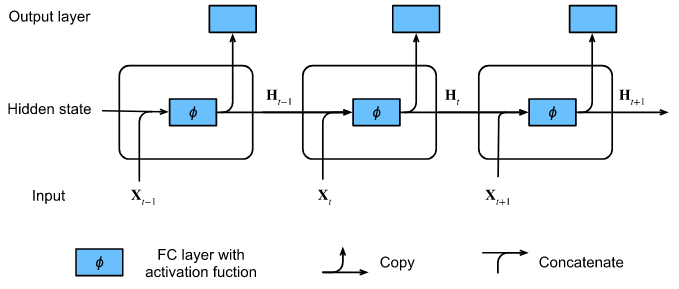

## Modelo de linguagem para caracteres

### Como prever o próximo caracter baseando-se no atual e nos anteriores?

Exemplo com minibatch = 1.



Durante o processo de treinamento:
- softmax na saída da camada de saída para cada instante
- cross-entropy para calcular o erro entre a saída do modelo e o rótulo. 

A saída $\mathbf{O}_{3}$, por exemplo, é determinada pela seqüência de texto "m", "a", e "c". 

Como o próximo caractere da seqüência nos dados de treinamento é "h", o erro de  dependerá da distribuição de probabilidade do próximo caractere gerado com base na seqüência de características "m", "a", "c" e o rótulo "h" deste instante.

### Como medir a qualidade do modelo?

_cross-entropy loss_ normalizada pelo tamanho da sequência ($n$):

$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1)$$,

onde $x_t$ é o token corrente observado e $P$ é dado por um modelo de linguagem treinado.

A comunidade de PLN prefere o cálculo da **PERPLEXIDADE**

$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right)$$

$\to$ reflete a média harmônica do número de escolhas reais possíveis ao se decidir sobre que token escolher na sequência.

## Exemplo prático

### Leitura do dataset
Livro The Time Machine, de H. G. Wells: https://www.gutenberg.org/files/35/35-0.txt

In [15]:
%matplotlib inline
import math
from mxnet import autograd, gluon, np, npx
import aux

npx.set_np()

batch_size, num_steps = 32, 35
train_iter, vocab = aux.load_data_time_machine(batch_size, num_steps)

### Representação do vetor de características: _One-Hot Encoding_

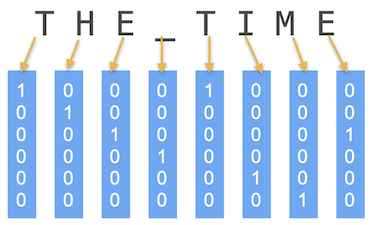

In [16]:
npx.one_hot(np.array([0, 2]), len(vocab))

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Inicialização dos parâmetros do modelo

In [17]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return np.random.normal(scale=0.01, size=shape, ctx=device)

    # Parâmetros da camada oculta
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = np.zeros(num_hiddens, ctx=device)
    # Parâmetros da camada de saída
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=device)
    # Gradientes
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

### Definição da RNN

In [18]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (np.zeros((batch_size, num_hiddens), ctx=device),)

In [19]:
# Como computar o estado oculto e saída em um instante t

def rnn(inputs, state, params):
    # Forma dos `inputs`: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Forma de um input (`X`): (`batch_size`, `vocab_size`)
    # Atualiza os estados ocultos H de um minibatch, passo a passo. 
    for X in inputs:
        H = np.tanh(np.dot(X, W_xh) + np.dot(H, W_hh) + b_h)
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H,)

In [20]:
# Classe para encapsular todas as funções e armazenar os parâmetros

class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = npx.one_hot(X.T, self.vocab_size)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, ctx):
        return self.init_state(batch_size, self.num_hiddens, ctx)

In [21]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, aux.try_gpu(), get_params,
                      init_rnn_state, rnn)
#state = net.begin_state(X.shape[0], d2l.try_gpu())

### Testar função de previsão

Gera novos caracteres a partir da sequência passada em `prefix` 

In [22]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    state = net.begin_state(batch_size=1, ctx=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: np.array([outputs[-1]], ctx=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Prevê `num_preds` passos
        # Saída do instante anterior é usada como
        # entrada do instante atual
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [23]:
# Testando com o pedaço de entrada especificado (sequência de caracteres)
# e especificando quantos novos caracteres queremos prever

predict_ch8('time traveller ', 10, net, vocab, aux.try_gpu())

'time traveller tkfzwtkybm'

### OBS:  Recorte do Gradiente para evitar divergir (_gradient clipping_)

Para uma seqüência de comprimento 𝑇, calculamos os gradientes sobre estes instantes 𝑇 em uma iteração $\implies$ cadeia de produtório durante o _backpropagation_ $\implies$ instabilidade numérica (explosão ou desaparecimento de gradientes), para 𝑇 grande. 

Portanto, os modelos RNN muitas vezes precisam de ajuda extra para estabilizar o treinamento:

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$$

Reescala o gradiente para um tamanho máximo de $\theta$.

In [24]:
def grad_clipping(net, theta):
    if isinstance(net, gluon.Block):
        params = [p.data() for p in net.collect_params().values()]
    else:
        params = net.params
    norm = math.sqrt(sum((p.grad**2).sum() for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### Treinamento da RNN

In [25]:
# Função de treinamento para uma única época

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, aux.Timer()
    metric = aux.Accumulator(2)  # Soma do erro de treinamento, número de tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Inicializa `state` na primeira iteração ou ao usar random sampling
            state = net.begin_state(batch_size=X.shape[0], ctx=device)
        else:
            for s in state:
                s.detach()
        y = Y.T.reshape(-1)
        X, y = X.as_in_ctx(device), y.as_in_ctx(device)
        with autograd.record():
            y_hat, state = net(X, state)
            l = loss(y_hat, y).mean()
        l.backward()
        
        # Recorte do gradiente (gradient clipping)
        grad_clipping(net, 1)
        
        updater(batch_size=1)
        metric.add(l * y.size, y.size)
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [26]:
# Função de treinamento

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    
    # Para plotar gráfico de perplexidade ao longo das épocas, descomentar linhas abaixo
    #animator = aux.Animator(xlabel='epoch', ylabel='perplexity',
    #                        legend=['train'], xlim=[10, num_epochs])
    
    # Inicialização
    if isinstance(net, gluon.Block):
        net.initialize(ctx=device, force_reinit=True, init=init.Normal(0.01))
        trainer = gluon.Trainer(net.collect_params(), 'sgd',
                                {'learning_rate': lr})
        updater = lambda batch_size: trainer.step(batch_size)
    else:
        updater = lambda batch_size: aux.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    
    # Treinamento e previsão
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        
        #Para plotar gráfico de perplexidade ao longo das épocas, descomentar linhas abaixo
        #if (epoch + 1) % 10 == 0:
        #    animator.add(epoch + 1, [ppl])
            
        # Coloquei para imprimir a qualidade da previsão a cada 50 épocas de treinamento 
        if (epoch + 1) % 50 == 0:
            print(f'perplexidade {ppl:.1f}, {speed:.1f} tokens/seg no {str(device)}')
            print('-',predict('time traveller'))
            print('-',predict('traveller'))

In [ ]:
# Execução do treinamento
# Número maior de épocas já que só foram utilizados 10k tokens do dataset

num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, aux.try_gpu())

**E se substituíssemos a função `tanh` por `ReLU` será precisaríamos do _clipping_?**

### Seção 8.6 de [Dive into Deep Learning](https://d2l.ai/index.html) traz versão concisa com `mxnet.gluon` 

# Referências para estudo

## Capítulo 8 de [Dive into Deep Learning](https://d2l.ai/index.html)